In [1]:
import os

In [2]:
data_path = os.path.join(os.getcwd(), "archive", "data", "data")
images_names = os.listdir(data_path)

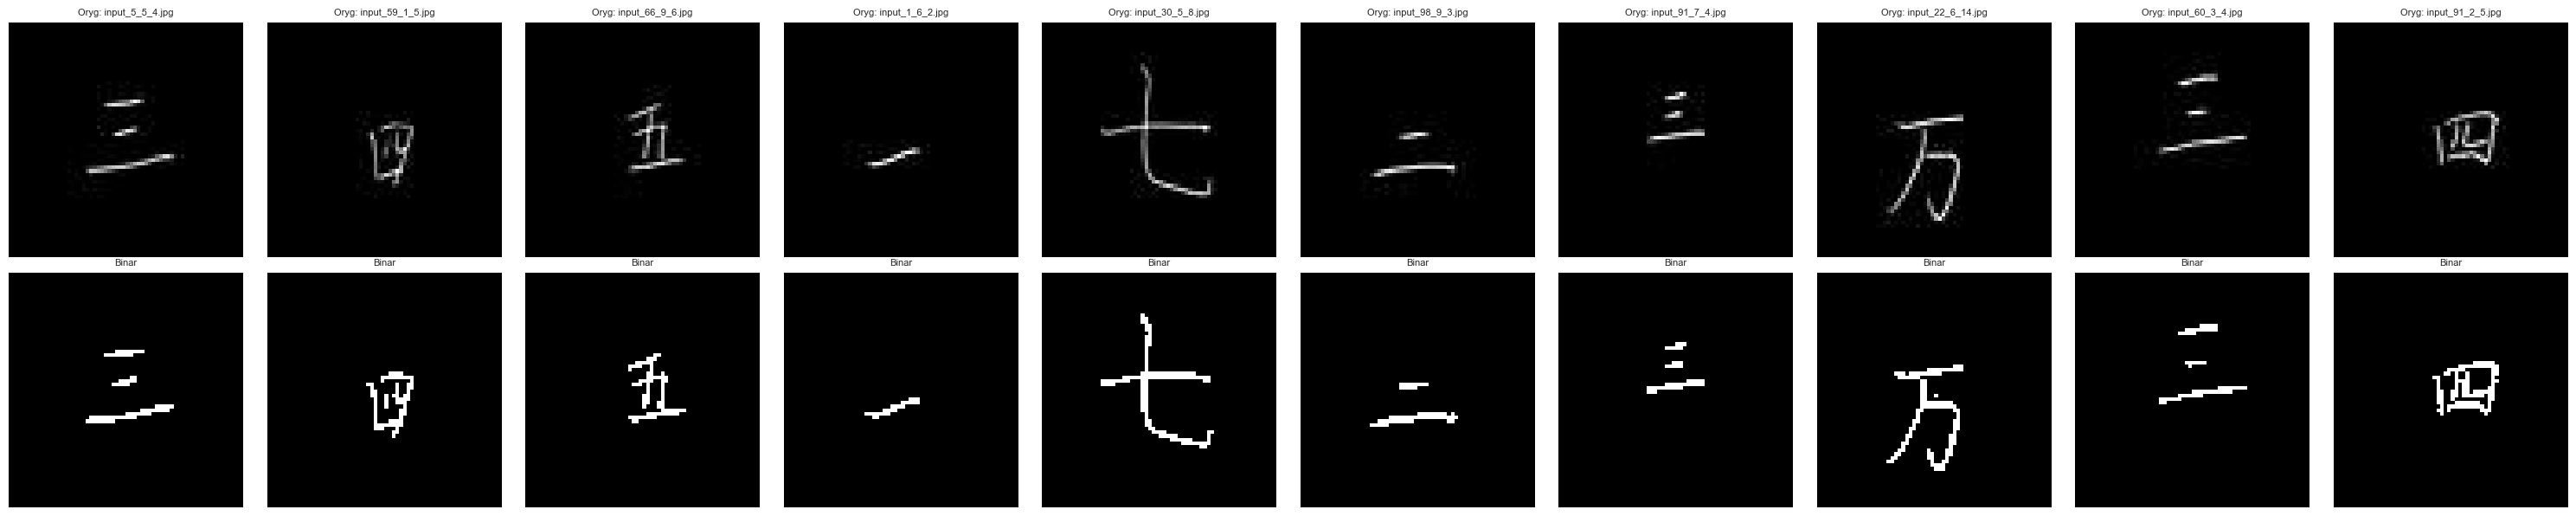

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def binarize_image(image: Image.Image, threshold: int = 20) -> Image.Image:
    """
    Binarizes a PIL image.

    Parameters:
        image (PIL.Image.Image): Input image.
        threshold (int): Threshold value (0-255). Default is 128.

    Returns:
        PIL.Image.Image: Binarized image.
    """
    # Convert to grayscale
    grayscale = image.convert("L")
    # Apply threshold
    binary = grayscale.point(lambda x: 255 if x > threshold else 0, mode='1')
    return binary

num_images = 10
threshold = 30

# Ścieżka do danych
data_path = os.path.join(os.getcwd(), "archive", "data", "data")
images_names = os.listdir(data_path)
sample_images = random.sample(images_names, num_images)

# Tworzenie wykresu
plt.figure(figsize=(3 * num_images, 6))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(data_path, img_name)
    image = Image.open(img_path)
    bin_image = binarize_image(image.copy(), threshold)

    # Oryginalny obraz
    plt.subplot(2, num_images, i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Oryg: {img_name}", fontsize=8)
    plt.axis("off")

    # Binarny obraz
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(bin_image, cmap="gray")
    plt.title(f"Binar", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()



# Applying Markov-Chain denoising on one image

In [4]:
import ising
import importlib
importlib.reload(ising)
import numpy as np
import pandas as pd

In [5]:
def load_image(idx, data_path="archive/data/data", csv_path="archive/chinese_mnist.csv"):
    """
    Ładuje obraz i dane z pliku CSV według indeksu.

    Parameters:
        idx (int): Indeks wiersza w CSV.
        data_path (str): Ścieżka do folderu z obrazami.
        csv_path (str): Ścieżka do pliku CSV z metadanymi.

    Returns:
        PIL.Image.Image: Załadowany obraz.
        dict: Dane z odpowiadającego wiersza CSV.
    """
    # Wczytaj dane CSV
    df = pd.read_csv(csv_path)

    # Sprawdź zakres indeksu
    if idx < 0 or idx >= len(df):
        raise IndexError(f"Index {idx} poza zakresem (0 - {len(df) - 1})")

    # Pobierz wiersz
    row = df.iloc[idx]
    suite_id = row['suite_id']
    sample_id = row['sample_id']
    code = row['code']

    # Zbuduj nazwę pliku
    filename = f"input_{suite_id}_{sample_id}_{code}.jpg"
    img_path = os.path.join(data_path, filename)

    # Wczytaj obraz
    image = Image.open(img_path)
    image = binarize_image(image)

    # Zwróć obraz i dane z wiersza jako słownik
    return image, row.to_dict()


Znak chiński: 九


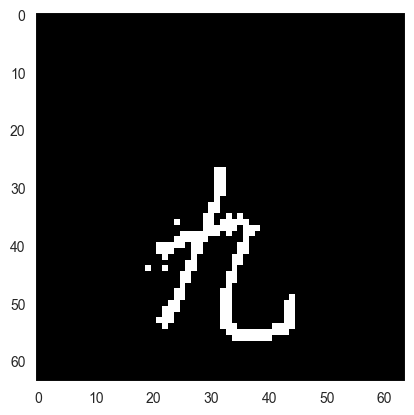

In [8]:
img, meta = load_image(0)
print("Znak chiński:", meta["character"])
plt.imshow(img, cmap="gray")
plt.grid(False)

In [9]:
def magnetize_image(image: np.ndarray) -> np.ndarray:
    if image.ndim == 3 and image.shape[2] == 1:
        image = image[:, :, 0]

    return 1 - 2 * image.astype(np.float64)

Znak chiński: 九 Values: (np.float64(-1.0), np.float64(1.0))


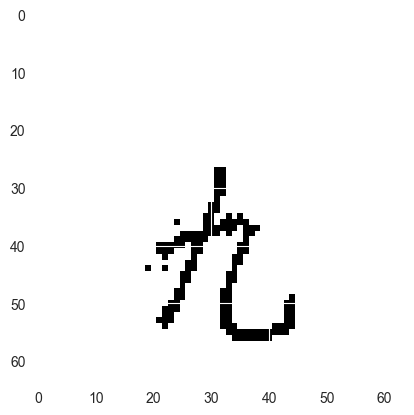

In [10]:
magnetized_img = magnetize_image(np.array(img))
print("Znak chiński:", meta["character"], "Values:", (magnetized_img.min(), magnetized_img.max()))
plt.imshow(magnetized_img, cmap="gray")

In [11]:
def add_flip_noise(image: np.ndarray, q: float = 0.9, show: bool = False) -> np.ndarray:
    if not np.all(np.isin(image, [-1, 1])):
        raise ValueError("Obraz musi zawierać tylko wartości -1 i 1.")

    noise = np.random.random(size=image.shape) > q  # True tam, gdzie odwracamy
    noisy = np.array(image, copy=True)
    noisy[noise] = -noisy[noise]

    if show:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes.imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
        axes.set_title(f"Obraz z szumem (q={q})")
        axes.axis("off")
        plt.show()

    return noisy

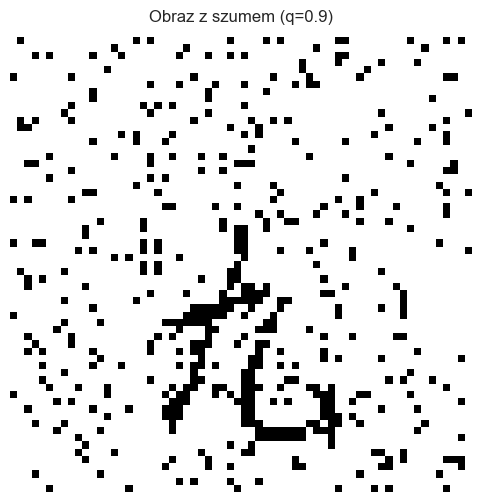

In [12]:
noisy = add_flip_noise(magnetized_img, q= 0.9, show=True)

In [13]:
def dice_score(pred: np.ndarray, target: np.ndarray) -> float:
    pred = pred.flatten()
    target = target.flatten()

    # Zamień -1 → 1, 1 → 0
    pred = (pred == -1).astype(np.uint8)
    target = (target == -1).astype(np.uint8)

    intersection = np.sum(pred & target)
    total = np.sum(pred) + np.sum(target)

    if total == 0:
        return 1.0  # Obie maski puste

    return 2.0 * intersection / total


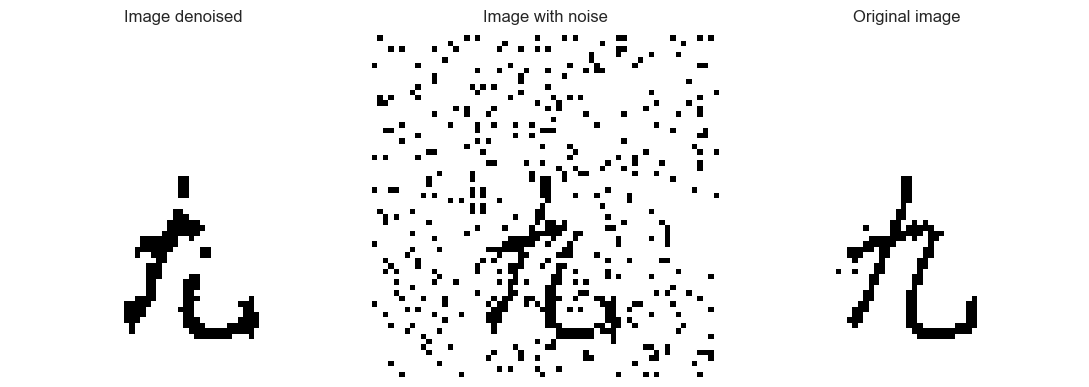

In [14]:
avg = ising.IsingDeNoise(noisy, 0.9)
avg[avg >= 0] = 1
avg[avg < 0] = -1


fig, axes = plt.subplots(ncols=3, figsize=(11, 6))
axes[0].imshow(avg, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[0].set_title("Image denoised")
axes[1].imshow(noisy, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[1].set_title("Image with noise")
axes[2].imshow(magnetized_img, cmap=cm.gray, aspect="equal", interpolation="none", vmin=-1, vmax=1)
axes[2].set_title("Original image")

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [15]:
dice_denoised = dice_score(avg, magnetized_img)
dice_noisy = dice_score(noisy, magnetized_img)

print(f"Dice score (denoised vs original): {dice_denoised:.4f}")
print(f"Dice score (noisy vs original):    {dice_noisy:.4f}")

Dice score (denoised vs original): 0.7913
Dice score (noisy vs original):    0.4174


# Noisiness vs DICE

## Small noisiness parameter in the chain

In [22]:
q_values = [0.5,0.75,0.9, 0.95]
csv_path = "archive/chinese_mnist.csv"
df_csv = pd.read_csv(csv_path)
total_images = len(df_csv)

num_images = 200
selected_indices = np.random.choice(total_images, size=num_images, replace=False)

In [23]:
import numpy as np
import pandas as pd
from tqdm import tqdm

results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising.IsingDeNoise(noisy, 0.9)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "image_value": info["value"],
            "image_character": info["character"],
            "suite_id": info['suite_id'],
            "sample_id": info['sample_id'],
            "code": info['code'],
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)


Processing images: 100%|██████████| 200/200 [28:06<00:00,  8.43s/it]


In [24]:
df_results.to_csv("ising_denoising_results.csv", index=False)

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dice_boxplots(df, highlight_q=0.9):
    df = df.copy()
    df["improvement"] = df["denoised_dice"] - df["noise_dice"]

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    sns.boxplot(data=df, x="q", y="denoised_dice", ax=axes[0])
    axes[0].set_title("Denoised Dice vs q")
    axes[0].set_xlabel("q")
    axes[0].set_ylabel("Dice score")
    axes[0].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    sns.boxplot(data=df, x="q", y="noise_dice", ax=axes[1])
    axes[1].set_title("Noisy Dice vs q")
    axes[1].set_xlabel("q")
    axes[1].set_ylabel("")
    axes[1].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    sns.boxplot(data=df, x="q", y="improvement", ax=axes[2])
    axes[2].set_title("Improvement (denoised - noisy) vs q")
    axes[2].set_xlabel("q")
    axes[2].set_ylabel("")
    axes[2].axvline(x=df["q"].sort_values().unique().tolist().index(highlight_q), color="red", linestyle="--")

    plt.tight_layout()
    plt.show()

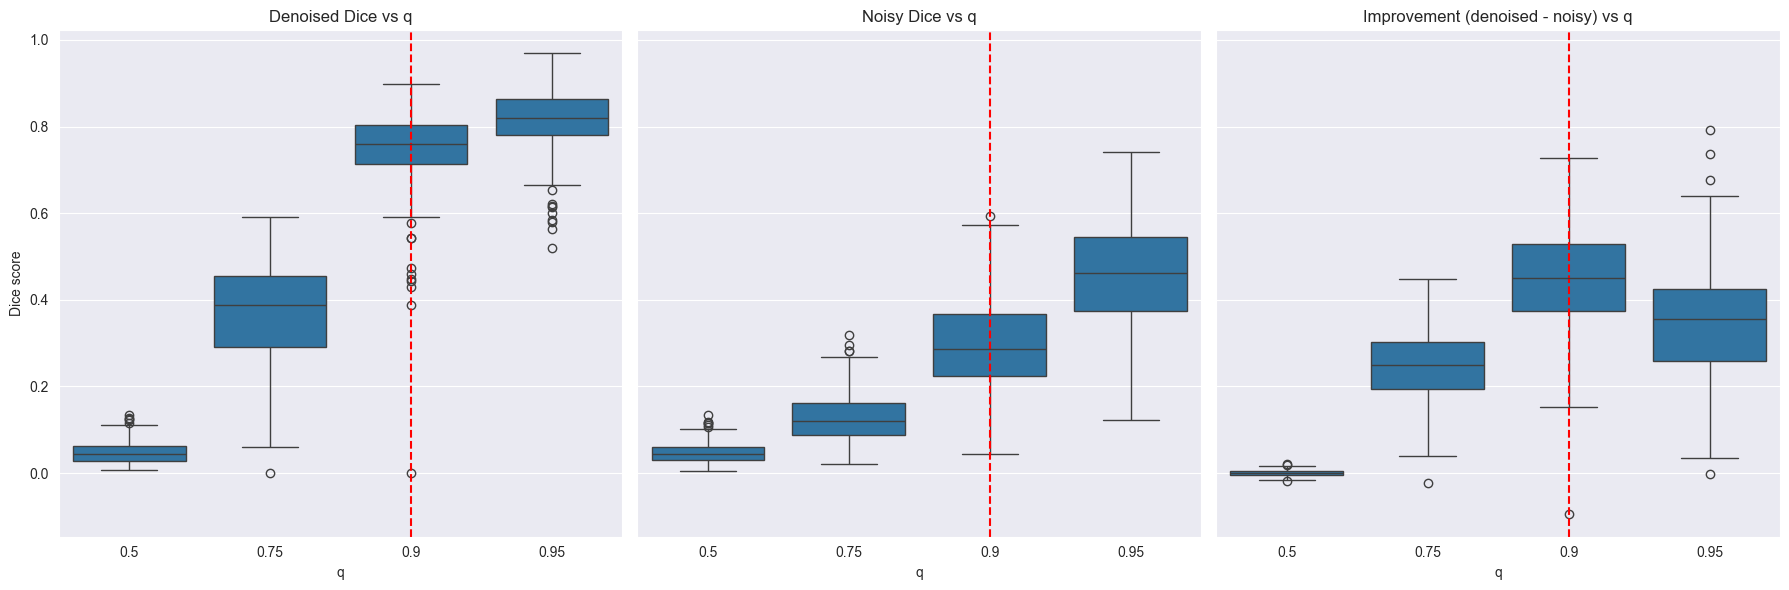

In [26]:
plot_dice_boxplots(df_results)

## Big noisiness parameter in the chain

In [27]:
import numpy as np
import pandas as pd
from tqdm import tqdm

results = []

for idx in tqdm(selected_indices, desc="Processing images"):
    image, info = load_image(idx)
    magnetized = magnetize_image(np.array(image))

    for q in q_values:
        noisy = add_flip_noise(magnetized, q=q, show=False)
        denoised = ising.IsingDeNoise(noisy, 0.75)
        denoised[denoised >= 0] = 1
        denoised[denoised < 0] = -1

        dice_denoised = dice_score(denoised, magnetized)
        dice_noisy = dice_score(noisy, magnetized)

        results.append({
            "image_value": info["value"],
            "image_character": info["character"],
            "suite_id": info['suite_id'],
            "sample_id": info['sample_id'],
            "code": info['code'],
            "q": q,
            "denoised_dice": dice_denoised,
            "noise_dice": dice_noisy
        })

df_results = pd.DataFrame(results)


Processing images: 100%|██████████| 200/200 [32:56<00:00,  9.88s/it] 


In [28]:
df_results.to_csv("ising_denoising_results_small_q.csv", index=False)

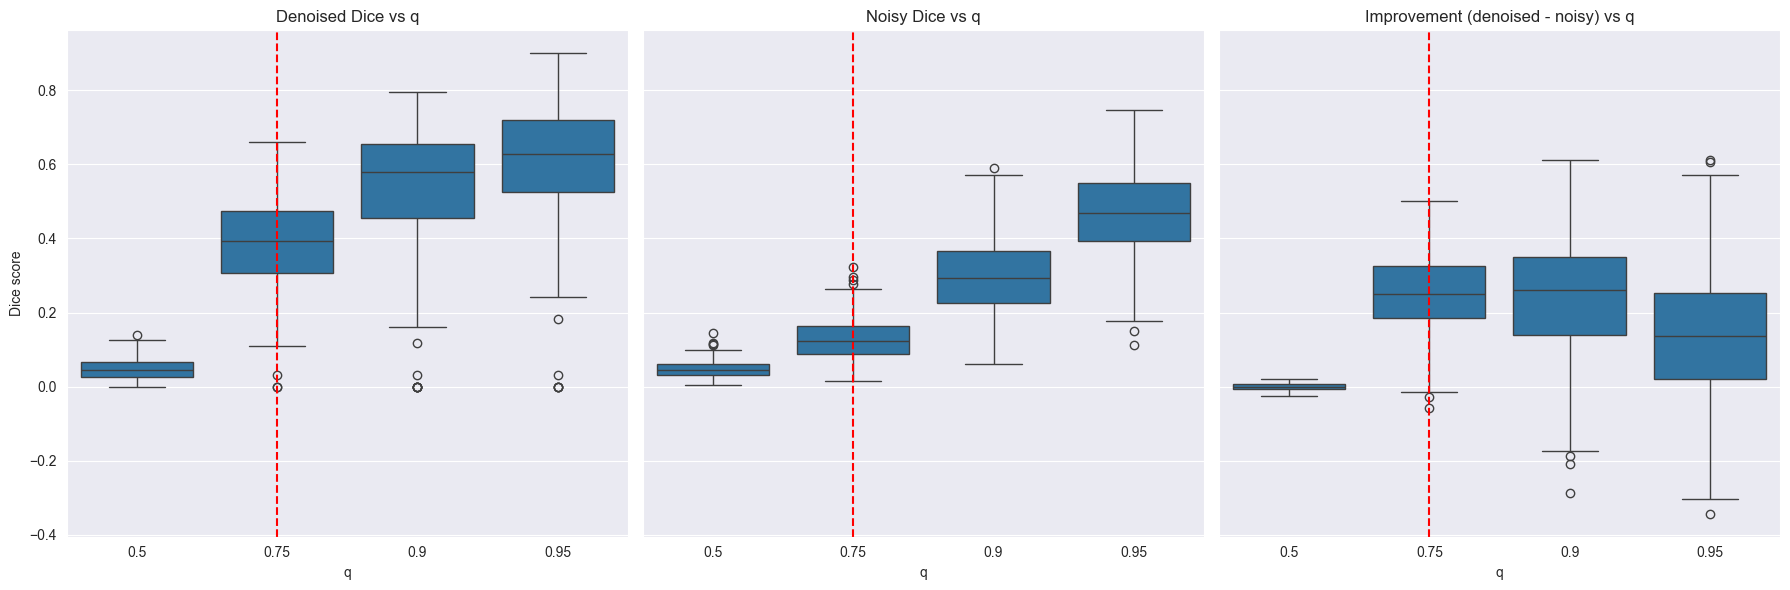

In [29]:
plot_dice_boxplots(df_results, highlight_q=0.75)

# Testing

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

def test_distribution(df, column="denoised_dice", alpha=0.05, plot=True):
    results = []
    for q_val in sorted(df["q"].unique()):
        subset = df[df["q"] == q_val][column]
        stat, p_value = shapiro(subset)
        normality = p_value > alpha
        results.append({
            "q": q_val,
            "statistic": stat,
            "p_value": p_value,
            "normality": normality
        })

    res_df = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(8,5))
        sns.barplot(data=res_df, x="q", y="p_value", color="steelblue")

        plt.axhline(alpha, color="red", linestyle="--", label=f"Poziom istotności ({alpha})")

        for i, row in res_df.iterrows():
            if not row["normality"]:
                plt.gca().patches[i].set_alpha(0.4)

        plt.title(f"Test Shapiro-Wilka dla kolumny '{column}'")
        plt.ylabel("p-value")
        plt.xlabel("q")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return res_df

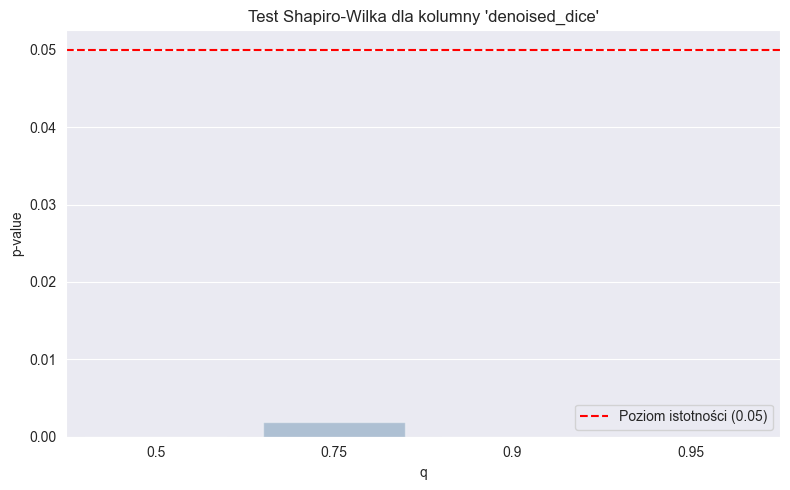

,q,statistic,p_value,normality
0,0.50,0.946619,9.029767e-07,False
1,0.75,0.976497,1.947200e-03,False
2,0.90,0.795457,1.848311e-15,False
3,0.95,0.923120,9.921677e-09,False


In [33]:
df_1 = pd.read_csv("ising_denoising_results.csv")
test_distribution(df_1)

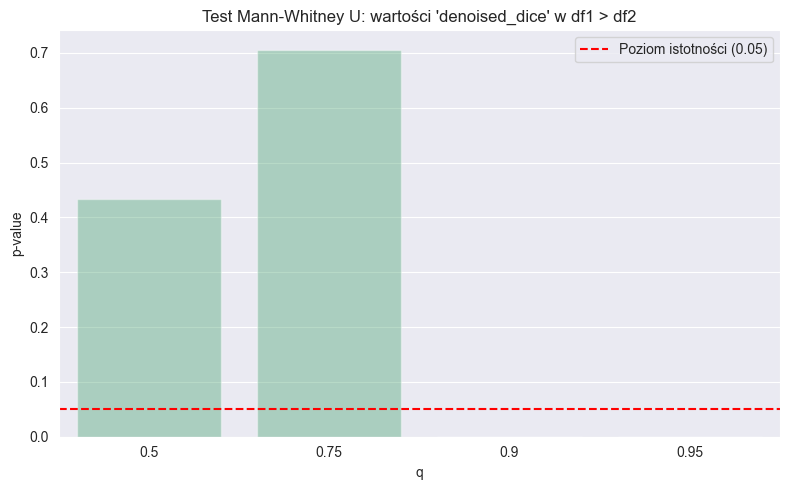

      q  statistic       p_value  higher_in_df1
0  0.50    20196.0  4.328603e-01          False
1  0.75    19374.5  7.059035e-01          False
2  0.90    36178.5  8.580078e-45           True
3  0.95    37065.5  1.320059e-49           True


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

def wilcoxon_compare(df1, df2, column="denoised_dice", alpha=0.05, plot=True):
    results = []

    q_values = sorted(set(df1["q"]).intersection(df2["q"]))

    for q_val in q_values:
        group1 = df1[df1["q"] == q_val][column]
        group2 = df2[df2["q"] == q_val][column]

        stat, p_value = mannwhitneyu(group1, group2, alternative="greater")

        results.append({
            "q": q_val,
            "statistic": stat,
            "p_value": p_value,
            "higher_in_df1": p_value < alpha
        })

    res_df = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(8,5))
        sns.barplot(data=res_df, x="q", y="p_value", color="mediumseagreen")

        plt.axhline(alpha, color="red", linestyle="--", label=f"Poziom istotności ({alpha})")

        # Półprzezroczystość słupków z brakiem istotności
        for i, row in res_df.iterrows():
            if not row["higher_in_df1"]:
                plt.gca().patches[i].set_alpha(0.4)

        plt.title(f"Test Mann-Whitney U: H0:  df1[{column}] <= df2[{column}]")
        plt.xlabel("q")
        plt.ylabel("p-value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return res_df

# Przykład użycia:
df1 = pd.read_csv("ising_denoising_results.csv")
df2 = pd.read_csv("ising_denoising_results_small_q.csv")

test_results = wilcoxon_compare(df1, df2, column="denoised_dice", alpha=0.05, plot=True)
print(test_results)
